# Survival Analysis: Democracy and dictatorship 
[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/09/12

The objective of this notebook is to estimate the probability of survival of a government since it takes office until it is disolved.

We will perform this survival analysis with [lifelines](https://lifelines.readthedocs.io/en/latest/).

In [0]:
# install lifelines
!pip install -q lifelines

In [0]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [0]:
# download the dataset
from lifelines.datasets import load_dd

df = load_dd()
df = df[['ctryname', 'un_region_name', 'un_continent_name', 'ehead', 'democracy', 'regime', 'start_year', 'duration', 'observed']]




This dataset contains a classification of political regimes as democracy and dictatorship. 

* Classification of democracies as 
  + parliamentary, 
  + semi-presidential (mixed), and 
  + presidential. 
  
* Classification of dictatorships as 
  + military, 
  + civilian, and 
  + royal. 
  
Coverage: 202 countries, from 1946 or year of independence to 2008.

**References**

José Antonio Cheibub, Jennifer Gandhi, and James Raymond Vreeland. [“Democracy and Dictatorship Revisited.”](https://doi.org/10.1007/s11127-009-9491-2) Public Choice, vol. 143, no. 2-1, pp. 67-101, 2010.

In [4]:
# show last 10 rows
df.tail(10)

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
1798,Yugoslavia,Southern Europe,Europe,Stipe Suvar,Non-democracy,Civilian Dict,1988,1,1
1799,Yugoslavia,Southern Europe,Europe,Milan Pancevski,Non-democracy,Civilian Dict,1989,1,1
1800,Yugoslavia,Southern Europe,Europe,Borisav Jovic,Non-democracy,Civilian Dict,1990,1,0
1801,Zambia,Eastern Africa,Africa,Kenneth Kaunda,Non-democracy,Civilian Dict,1964,27,1
1802,Zambia,Eastern Africa,Africa,Frederick Chiluba,Non-democracy,Civilian Dict,1991,11,1
1803,Zambia,Eastern Africa,Africa,Levy Patrick Mwanawasa,Non-democracy,Civilian Dict,2002,6,1
1804,Zambia,Eastern Africa,Africa,Rupiah Bwezani Banda,Non-democracy,Civilian Dict,2008,1,0
1805,Zimbabwe,Eastern Africa,Africa,Ian Smith,Non-democracy,Civilian Dict,1965,14,1
1806,Zimbabwe,Eastern Africa,Africa,Abel Muzorewa,Non-democracy,Civilian Dict,1979,1,1
1807,Zimbabwe,Eastern Africa,Africa,Robert Mugabe,Non-democracy,Civilian Dict,1980,29,0


One of the main challenges of survival analysis is **right censoring**, i.e., by the end of the study, the event of interest (for example, in medicine 'death of a patient' or in this dataset 'government disolution') has only occurred for a subset of the observations.

The right censoring in this dataset is given by the column name 'observed' and it's a variable which can take value 1 if the disolution of the government has been observed or 0 if it was still in power at the end of the study in 2008 or if there was no disolution, for example, the president died in office. For example, in the US, the right censored observations are George W. Bush and John Kennedy as we see next.

In [5]:
format_dict = {'ehead':'{}','duration':'{}', 'observed':'{}'}
(df.query('ctryname == "United States of America"')[['ehead', 'duration', 'observed']].style.format(format_dict)
  .hide_index()
  .highlight_min('observed', color='lightgreen'))

ehead,duration,observed
Harry Truman,7,1
Dwight D. Eisenhower,8,1
John Kennedy,2,0
Lyndon Johnson,6,1
Richard Nixon,5,1
Gerald Ford,3,1
Jimmy Carter,4,1
Ronald Reagan,8,1
George Bush,4,1
Bill Clinton,8,1


In [6]:
print(f'Number of samples: {len(df)}')
print(f'Number of right censored samples: {len(df.query("observed == 0"))}')
print(f'Percentage of right censored samples: {100*len(df.query("observed == 0"))/len(df):.1f}%')

Number of samples: 1808
Number of right censored samples: 340
Percentage of right censored samples: 18.8%


We use the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan–Meier_estimator) to estimate the probability of a government survival.

In [0]:
T = df['duration']
E = df['observed']

The median number of years of government survival is 4.0


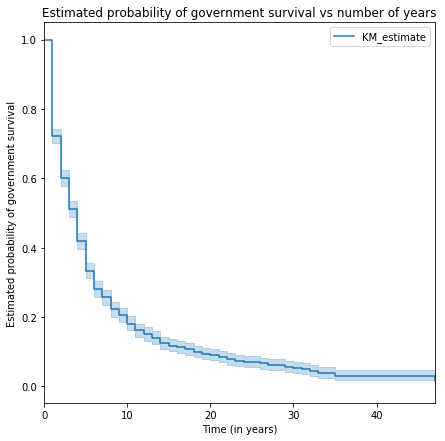

In [8]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T,E)
print(f'The median number of years of government survival is {kmf.median_survival_time_}')
plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [9]:
# probability of goverment survival for the first 10 years
kmf.survival_function_[:10]

,KM_estimate
timeline,
0.0,1.000000
1.0,0.721792
2.0,0.601973
3.0,0.510929
4.0,0.418835
5.0,0.334008
6.0,0.280902
7.0,0.256825
8.0,0.221975


This is the estimated probability of a government survival overall. The probability of a government lasting more than 10 years is smaller than 20%.

The confidence interval of this estimator is given as follows.

In [10]:
# confidence interval (with a confidence level of 95%) of the probability of government survival
kmf.confidence_interval_[:10]

,KM_estimate_upper_0.95,KM_estimate_lower_0.95
0.0,NaN,NaN
1.0,0.741841,0.700522
2.0,0.624308,0.578805
3.0,0.534126,0.487205
4.0,0.442242,0.395233
5.0,0.356952,0.311203
6.0,0.303218,0.258958
7.0,0.278769,0.235366
8.0,0.243268,0.201348
9.0,0.226095,0.184960


The median number of years for a Non-democracy is 6.0
The median number of years for a Democracy is 3.0


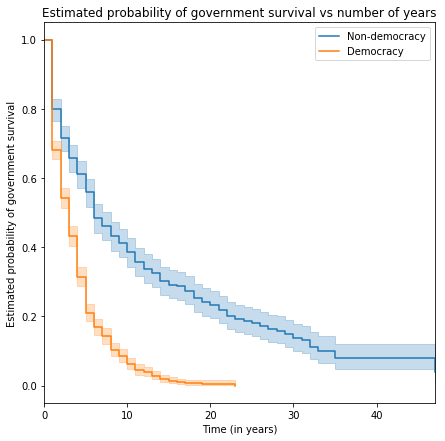

In [11]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['democracy'].unique():
  ix = df['democracy'] == r
  kmf.fit(T.loc[ix], E.loc[ix], label=r)
  print(f'The median number of years for a {r} is {kmf.median_survival_time_}')
  kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

Non democratic governments tend to last much longer than democratic governments as can be seen in the previous plot.

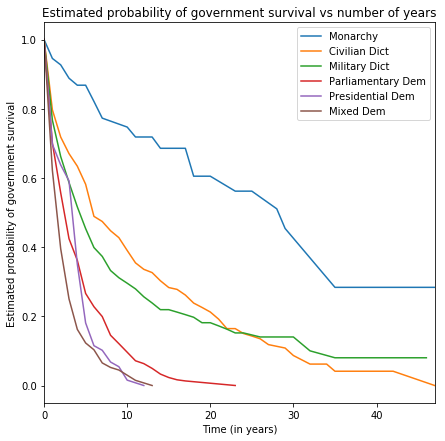

In [12]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['regime'].unique():
  ix = df['regime'] == r
  kmf.fit(T.loc[ix], E.loc[ix], label=r)
  kmf.survival_function_.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

Each democratic type of government (presidential, parliamentary, or mixed) tend to last less compared to military dictatorships, civilian dictatorships or monarchies.

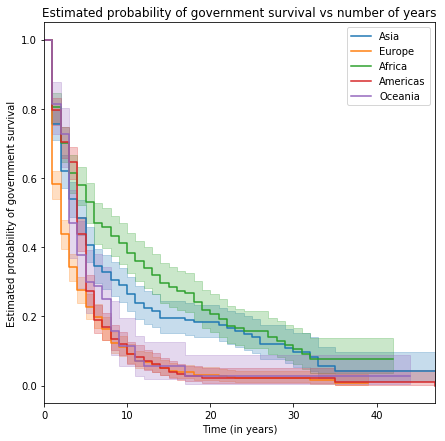

In [13]:
plt.figure(figsize=(7,7))
ax = plt.subplot(111)

for r in df['un_continent_name'].unique():
  ix = df['un_continent_name'] == r
  kmf.fit(T.loc[ix], E.loc[ix], label=r)
  kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

Africa and Asia to a less degree tend to have longer governments than the other continents.

In [14]:
df['un_region_name'].unique()

array(['Southern Asia', 'Southern Europe', 'Northern Africa',
       'Middle Africa', 'Caribbean', 'South America', 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Central America', 'Western Africa', 'Southern Africa',
       'South-Eastern Asia', 'Eastern Africa', 'Northern America',
       'Eastern Asia', 'Northern Europe', 'Melanesia', 'Central Asia',
       'Micronesia', 'Polynesia'], dtype=object)

In [0]:
ix_na = df['un_region_name'] == 'Northern America'
ix_sa = df['un_region_name'] == 'South America'
ix_we = df['un_region_name'] == 'Western Europe'
ix_ee = df['un_region_name'] == 'Eastern Europe'

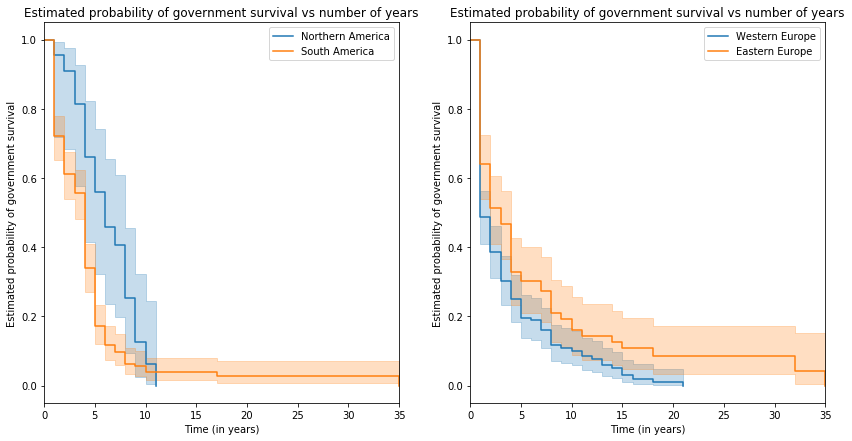

In [16]:
kmf_na = KaplanMeierFitter()
kmf_sa = KaplanMeierFitter()
kmf_we = KaplanMeierFitter()
kmf_ee = KaplanMeierFitter()

kmf_na.fit(T.loc[ix_na], E.loc[ix_na], label='Northern America')
kmf_sa.fit(T.loc[ix_sa], E.loc[ix_sa], label='South America')
kmf_we.fit(T.loc[ix_we], E.loc[ix_we], label='Western Europe')
kmf_ee.fit(T.loc[ix_ee], E.loc[ix_ee], label='Eastern Europe')

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121)
kmf_na.plot(ax=ax1)
kmf_sa.plot(ax=ax1)
ax2 = plt.subplot(122)
kmf_we.plot(ax=ax2)
kmf_ee.plot(ax=ax2)
ax1.set_title('Estimated probability of government survival vs number of years')
ax1.set(xlabel = 'Time (in years)', ylabel = 'Estimated probability of government survival')
ax2.set_title('Estimated probability of government survival vs number of years')
ax2.set(xlabel = 'Time (in years)', ylabel = 'Estimated probability of government survival')
plt.show()

### Chile and the rest of South America

In [17]:
df.query('ctryname == "Chile"')

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
290,Chile,South America,Americas,Gabriel Gonzalez Videla,Democracy,Presidential Dem,1946,6,1
291,Chile,South America,Americas,Carlos Ibanez del Campo,Democracy,Presidential Dem,1952,6,1
292,Chile,South America,Americas,Jorge Alessandri Rodriguez,Democracy,Presidential Dem,1958,6,1
293,Chile,South America,Americas,Eduardo Frei Montalva,Democracy,Presidential Dem,1964,6,1
294,Chile,South America,Americas,Salvador Allende Gossens,Democracy,Presidential Dem,1970,3,0
295,Chile,South America,Americas,Augusto Pinochet Ugarte,Non-democracy,Military Dict,1973,17,1
296,Chile,South America,Americas,Patricio Aylwin Azacar,Democracy,Presidential Dem,1990,4,1
297,Chile,South America,Americas,Eduardo Frei Ruiz-Tagle,Democracy,Presidential Dem,1994,6,1
298,Chile,South America,Americas,Ricardo Froilan Lagos Escobar,Democracy,Presidential Dem,2000,6,1
299,Chile,South America,Americas,Verï¿½nica Michelle Bachelet Jeria,Democracy,Presidential Dem,2006,3,0


In [0]:
ix_chile = df['ctryname'] == 'Chile'

In [0]:
list_sa_nochile = [ix_sa[i] and not ix_chile[i] for i in range(len(ix_sa))]
serie_sa_nochile = pd.Series(list_sa_nochile)

In [0]:
kmf_chile = KaplanMeierFitter()
kmf_sa_nochile = KaplanMeierFitter()

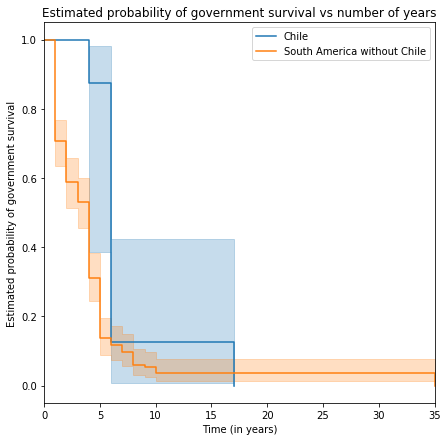

In [21]:
kmf_chile.fit(T.loc[ix_chile], E.loc[ix_chile], label='Chile')
kmf_sa_nochile.fit(T.loc[serie_sa_nochile], E.loc[serie_sa_nochile], label='South America without Chile')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)
kmf_chile.plot(ax=ax)
kmf_sa_nochile.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In Chile, we had 6 year governments and then the law changed to be 4 years. However, we also had a military dictatorship which lasted 17 years as can be seen in the estimation in the previous plot.

**Sources:**

[Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA) 